In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import numpy as np
import matplotlib.pyplot as plt

class MultiBandit:

	def __init__(self,k=10,steps=1000,num_tests=2000,strategy='e_greedy',update_method='sample_average',epsilon=0,alpha=0.1,init_q=0,same_qs=False,c=2,stationary=True):
		self.k=k
		self.epsilon=epsilon
		self.steps=steps
		self.num_tests=num_tests
		self.c=c
		self.alpha=alpha
		self.init_q=init_q
		self.same_qs=same_qs
		self.stationary=stationary

		strategy_list={'e_greedy':self.epsilon_greedy, 'UCB':self.UCB, 'optimistic':self.optimistic_value}
		self.update_method=update_method
		self.strategy=strategy_list[strategy]
		self.reset()


	def reset(self):
		self.means=self.gen_testbed_means()
		self.Q=np.ones(self.k)*self.init_q
		self.n=np.zeros(self.k)      	     # Number of times each action was selected 

	def gen_testbed_means(self):
		if self.same_qs:
			rand=np.random.randn(1)
			means=np.hstack([rand]*self.k)
		else:
			means=np.random.randn(self.k)
		return means

	def gen_reward(self):
		return self.means + np.random.randn(self.k)
  
	# For non_stationary problem
	def random_walk(self,std=0.01):
		self.means+=std*np.random.randn(self.k)


	# 3 action selection strategies are below-
	def epsilon_greedy(self):   
		if np.random.random() < self.epsilon:    # choose an action randomly
			return np.random.randint(0, self.Q.shape[0])
		else:    						         # choose the greedy action
			ind=np.where(np.max(self.Q)==self.Q)
			return np.random.choice(ind[0])      # break ties randomly

	def UCB(self):     
		t=self.n.sum()
		if t==0:
			term=self.Q
		else:
			term=self.Q + self.c*np.sqrt(np.log(t)/(self.n+1e-9))
		ind=np.where(np.max(term)==term)
		return np.random.choice(ind[0])          # break ties randomly

	def optimistic_value(self):
		self.epsilon=0
		return self.epsilon_greedy()             # use with epsilon=0

	# Method to update Q values 
	def update(self,choice,R):
		if self.update_method=='sample_average':
			alpha=1/(self.n[choice]+1)
		elif self.update_method=='constant_alpha':
			alpha=self.alpha
		self.Q[choice]+=alpha*(R-self.Q[choice])
		self.n[choice]+=1
	

	# Training loop
	def train(self):
		reward_matrix=np.zeros((self.num_tests,self.steps))
		opt_action_matrix=np.zeros((self.num_tests,self.steps))
		for i in range(self.num_tests):
			self.reset()
			optimal_action=np.argmax(self.means)
			
			for j in range(self.steps):
				if not self.stationary:
					self.random_walk()
					optimal_action=np.argmax(self.means)
				choice=self.strategy()            # choose an action
				R=self.gen_reward()[choice]	      # Generate a reward
				self.update(choice,R)
				
				reward_matrix[i,j]=R
				opt_action_matrix[i,j]=(choice==optimal_action)
   
		return opt_action_matrix.mean(axis=0), reward_matrix.mean(axis=0)
  

## Ans-1

In [0]:
samp_avg_obj=MultiBandit(k=10,steps=10000,num_tests=2000,strategy='e_greedy',update_method='sample_average',
                     epsilon=0.1,alpha=0.1,init_q=0,same_qs=True,stationary=False)

cons_alpha_obj=MultiBandit(k=10,steps=10000,num_tests=2000,strategy='e_greedy',update_method='constant_alpha',
                     epsilon=0.1,alpha=0.1,init_q=0,same_qs=True,stationary=False)

sample_optimal_action, sample_reward = samp_avg_obj.train()
cons_optimal_action, cons_reward = cons_alpha_obj.train()

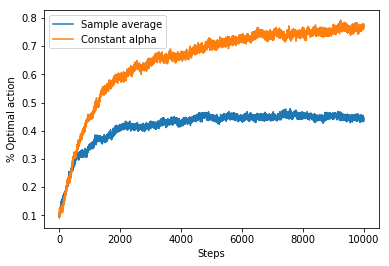

In [58]:
plt.plot(sample_optimal_action,label='Sample average')
plt.plot(cons_optimal_action,label='Constant alpha')
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()
plt.show()

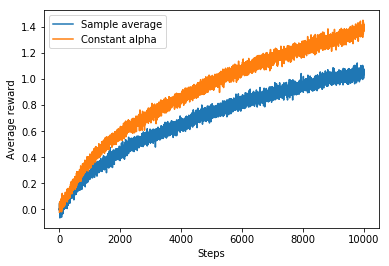

In [59]:
plt.plot(sample_reward,label='Sample average')
plt.plot(cons_reward,label='Constant alpha')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()
plt.show()

We see that in both of the above graphs, constant alpha method is better than the sample average. This is because constant alpha method puts higher weight on recent rewards and lower weight on earlier rewards.

## ANS-2

### **Stationary Case**

In [0]:
realistic_e_greedy=MultiBandit(k=10,steps=1000,num_tests=2000,strategy='e_greedy',update_method='constant_alpha',
                     epsilon=0.1,alpha=0.1,init_q=0,same_qs=False,stationary=True)

optimistic_e_greedy=MultiBandit(k=10,steps=1000,num_tests=2000,strategy='optimistic',update_method='constant_alpha',
                     alpha=0.1,init_q=5,same_qs=False,stationary=True)

realistic_optimal_action, _ = realistic_e_greedy.train()
optimistic_optimal_action, _ = optimistic_e_greedy.train()

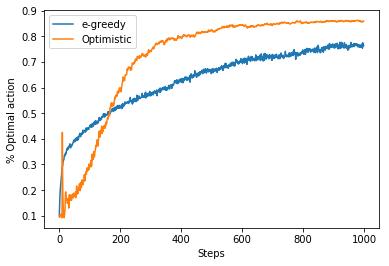

In [65]:
plt.plot(realistic_optimal_action,label='e-greedy')
plt.plot(optimistic_optimal_action,label='Optimistic')
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()
plt.show()

### **Non-Stationary Case**

In [0]:
realistic_e_greedy=MultiBandit(k=10,steps=1000,num_tests=2000,strategy='e_greedy',update_method='constant_alpha',
                     epsilon=0.1,alpha=0.1,init_q=0,same_qs=False,stationary=False)

optimistic_e_greedy=MultiBandit(k=10,steps=1000,num_tests=2000,strategy='optimistic',update_method='constant_alpha',
                     alpha=0.1,init_q=5,same_qs=False,stationary=False)

realistic_optimal_action, _ = realistic_e_greedy.train()
optimistic_optimal_action, _ = optimistic_e_greedy.train()

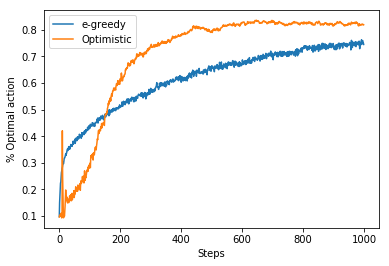

In [67]:
plt.plot(realistic_optimal_action,label='e-greedy')
plt.plot(optimistic_optimal_action,label='Optimistic')
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()
plt.show()

We see that optimistic value converges to lower value quickly in non-stationary case. This is because we are constantly changing the mean of all bandits.

e-greedy is almost same in both cases.

## **Ans-4**

### **Stationary Case**

In [0]:
e_greedy=MultiBandit(k=10,steps=1000,num_tests=2000,strategy='e_greedy',update_method='constant_alpha',
                     epsilon=0.1,alpha=0.1,init_q=0,stationary=True)

optimistic=MultiBandit(k=10,steps=1000,num_tests=2000,strategy='optimistic',update_method='constant_alpha',
                     alpha=0.1,init_q=5,stationary=True)

ucb=MultiBandit(k=10,steps=1000,num_tests=2000,strategy='UCB',update_method='constant_alpha',
                     c=0.4,alpha=0.1,init_q=0,stationary=True)

e_greedy_optimal_action, _ = e_greedy.train()
optimistic_optimal_action, _ = optimistic.train()
ucb_optimal_action, _ = ucb.train()

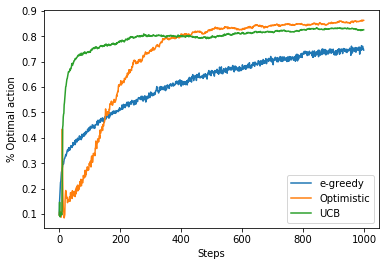

In [99]:
plt.plot(realistic_optimal_action,label='e-greedy')
plt.plot(optimistic_optimal_action,label='Optimistic')
plt.plot(ucb_optimal_action,label='UCB')
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()
plt.show()

We see that UCB converges fastest to the optimal action and is approximately equal to the value achieved by the optimistic method.

### **Non-Stationary Case**

In [0]:
e_greedy=MultiBandit(k=10,steps=1000,num_tests=2000,strategy='e_greedy',update_method='constant_alpha',
                     epsilon=0.1,alpha=0.1,init_q=0,stationary=False)

optimistic=MultiBandit(k=10,steps=1000,num_tests=2000,strategy='optimistic',update_method='constant_alpha',
                     alpha=0.1,init_q=5,stationary=False)

ucb=MultiBandit(k=10,steps=1000,num_tests=2000,strategy='UCB',update_method='constant_alpha',
                     c=0.4,alpha=0.1,init_q=0,stationary=False)

e_greedy_optimal_action, _ = e_greedy.train()
optimistic_optimal_action, _ = optimistic.train()
ucb_optimal_action, _ = ucb.train()

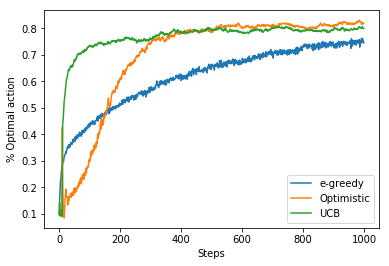

In [101]:
plt.plot(realistic_optimal_action,label='e-greedy')
plt.plot(optimistic_optimal_action,label='Optimistic')
plt.plot(ucb_optimal_action,label='UCB')
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()
plt.show()

We see that UCB converges fastest to the optimal action and is approximately equal to the value achieved by the optimistic method. Converged value is lower in non-stationary case as mean value of each bandit is constantly changing. 